# EcoDRR — Integrated GeoAI Risk Pipeline (v2)
This notebook stitches U-Net segmentation outputs with DEM & hydrology models to produce an integrated DRR risk pipeline.

In [ ]:
!pip install rasterio

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
print('Imports OK')

Imports OK


## 1. Preconditions
Requires outputs from segmentation and advanced modeling:
- /content/data/landcover_unet.tif
- /content/data/dem_export.tif
- /content/data/chirps_export.tif
- /content/data/ndvi_recent_export.tif & ndvi_hist_export.tif
Ensure these are present or run earlier notebooks.

In [3]:
paths = {
    'landcover':'/content/data/landcover_unet.tif',
    'dem':'/content/data/dem_export.tif',
    'chirps':'/content/data/chirps_export.tif',
    'ndvi_recent':'/content/data/ndvi_recent_export.tif',
    'ndvi_hist':'/content/data/ndvi_hist_export.tif'
}
for k,p in paths.items(): print(k, os.path.exists(p))

landcover True
dem True
chirps True
ndvi_recent True
ndvi_hist True


## 2. Load key layers (with safe fallback)

In [4]:
def load_or_none(p):
    if os.path.exists(p):
        with rasterio.open(p) as src:
            return src.read(1), src.meta
    return None, None

lc, lc_meta = load_or_none(paths['landcover'])
dem, dem_meta = load_or_none(paths['dem'])
chirps, chirps_meta = load_or_none(paths['chirps'])
ndvi_r, ndvi_r_meta = load_or_none(paths['ndvi_recent'])
ndvi_h, ndvi_h_meta = load_or_none(paths['ndvi_hist'])
print('Loaded:', [x is not None for x in (lc, dem, chirps, ndvi_r, ndvi_h)])

Loaded: [True, True, True, True, True]


## 3. Quick checks and resampling
Ensure all rasters align: same shape and transform. If not, resample to DEM resolution.

In [6]:
def resample_to(ref_meta, arr, arr_meta):
    # simple nearest resample using rasterio.warp not added to keep dependencies minimal
    import numpy as np
    if arr.shape == (ref_meta['height'], ref_meta['width']):
        return arr
    # fallback: center-crop or pad
    out = np.zeros((ref_meta['height'], ref_meta['width']), dtype=arr.dtype)
    h = min(out.shape[0], arr.shape[0])
    w = min(out.shape[1], arr.shape[1])
    out[:h,:w] = arr[:h,:w]
    return out

if dem is not None:
    if lc is not None:
        lc = resample_to(dem_meta, lc, lc_meta)
    if chirps is not None:
        chirps = resample_to(dem_meta, chirps, chirps_meta)
    if ndvi_r is not None and ndvi_h is not None:
        ndvi_r = resample_to(dem_meta, ndvi_r, ndvi_r_meta)
        ndvi_h = resample_to(dem_meta, ndvi_h, ndvi_h_meta)
print('Resampling done')

Resampling done


## 4. Compute or load intermediate maps
Attempt to load existing outputs; if missing, compute small functions from AdvancedModeling.

In [7]:
def try_load(p):
    if os.path.exists(p):
        with rasterio.open(p) as src:
            return src.read(1)
    return None

flood = try_load('/content/data/flood_proxy.tif')
runoff = try_load('/content/data/runoff_map.tif')
ndvi_delta = try_load('/content/data/ndvi_delta.tif')
hq = try_load('/content/data/habitat_quality.tif')

print('Intermediate presence:', [x is not None for x in (flood, runoff, ndvi_delta, hq)])

Intermediate presence: [True, True, True, True]


## 5. Integrated Risk Map
Use exposures from landcover and combine layers to create a final risk map.

In [13]:
from rasterio.enums import Resampling

def resample_to_landcover(arr_path, lc_meta):
    """Resample any raster to match landcover resolution & shape."""
    with rasterio.open(arr_path) as src:
        data = src.read(
            out_shape=(1, lc_meta['height'], lc_meta['width']),
            resampling=Resampling.bilinear
        )[0]
    return data

try:
    # 1. Load reference landcover
    lc, lc_meta = load_or_none(paths['landcover'])
    H_ref, W_ref = lc.shape
    print("Landcover reference grid:", lc.shape)

    # 2. Resample ALL input rasters to landcover grid
    flood = resample_to_landcover('/content/data/flood_proxy.tif', lc_meta)
    runoff = resample_to_landcover('/content/data/runoff_map.tif', lc_meta)
    ndvi_delta = resample_to_landcover('/content/data/ndvi_delta.tif', lc_meta)
    hq = resample_to_landcover('/content/data/habitat_quality.tif', lc_meta)

    print("Shapes after resample:")
    print("flood:", flood.shape)
    print("runoff:", runoff.shape)
    print("ndvi_delta:", ndvi_delta.shape)
    print("habitat_quality:", hq.shape)
    print("landcover:", lc.shape)

    # 3. Normalize hazards
    flood_n = (flood - flood.min()) / (flood.max() - flood.min() + 1e-9)
    runoff_n = (runoff - runoff.min()) / (runoff.max() - runoff.min() + 1e-9)
    H = (flood_n + runoff_n) / 2.0

    # 4. Exposure (built-up)
    Exposure = (lc == 3).astype(float)

    # 5. Vulnerability
    Vulnerability = (ndvi_delta < -0.05).astype(float)

    # 6. Ecosystem services
    ES = (hq - hq.min()) / (hq.max() - hq.min() + 1e-9)

    # 7. Final DRR Risk
    Risk = H * Exposure * (1 + Vulnerability) * (1 - ES)
    Risk = (Risk - Risk.min()) / (Risk.max() - Risk.min() + 1e-9)

    # 8. Save output
    out_risk = "/content/data/integrated_drr_risk_v2.tif"
    out_meta = lc_meta.copy()
    out_meta.update({"dtype": "float32", "count": 1})

    with rasterio.open(out_risk, "w", **out_meta) as dst:
        dst.write(Risk.astype("float32"), 1)

    print("Integrated DRR Risk Map saved →", out_risk)

except Exception as e:
    print("Error:", e)


Landcover reference grid: (128, 128)
Shapes after resample:
flood: (128, 128)
runoff: (128, 128)
ndvi_delta: (128, 128)
habitat_quality: (128, 128)
landcover: (128, 128)
Integrated DRR Risk Map saved → /content/data/integrated_drr_risk_v2.tif


## 6. Visualization & interpretation
Display integrated risk and components.

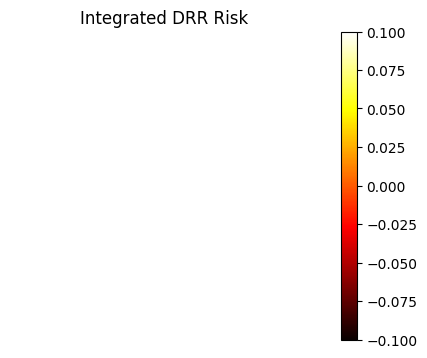

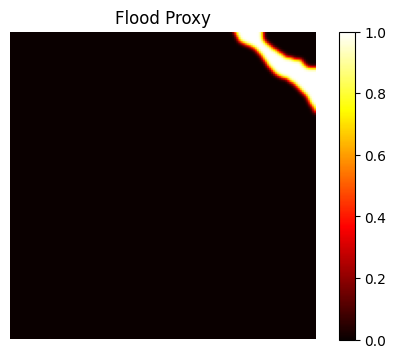

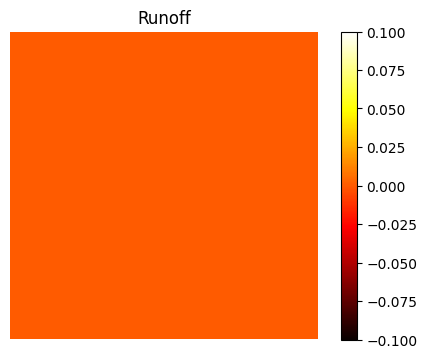

In [14]:
import matplotlib.pyplot as plt
for p, title in [('/content/data/integrated_drr_risk_v2.tif','Integrated DRR Risk'), ('/content/data/flood_proxy.tif','Flood Proxy'),('/content/data/runoff_map.tif','Runoff')]:
    if os.path.exists(p):
        with rasterio.open(p) as src:
            arr = src.read(1)
        plt.figure(figsize=(6,4)); plt.imshow(arr, cmap='hot'); plt.title(title); plt.colorbar(); plt.axis('off')
    else:
        print('Missing', p)


End of integrated pipeline notebook.